## Import

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
# from sklearn_pandas import DataFrameMapper
from collections import Counter
import datetime
import os
import matplotlib.pyplot as plt
# import seaborn as sns 
%matplotlib inline
import re
import math
import copy
# import cellbell
print(os.listdir('../kaggle/data'))

['kaggle_task.csv', 'kaggle_task.csv.zip', 'main_task.csv', 'main_task.csv.zip', 'sample_submission.csv']


In [20]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

## Data

In [21]:
df_train = pd.read_csv('../kaggle/data/main_task.csv')
df_test = pd.read_csv('../kaggle/data/kaggle_task.csv')
pd.set_option('display.max_columns', 200)
display(df_train.head(2))
display(df_test.head(2))

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944


In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 2.0+ MB


In [23]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 429.8+ KB


In [24]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Sample'] = 1 # помечаем где у нас трейн
df_test['Sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

## Cleaning and Preparing Data and small EDA on all values

### 1. Number of Reviews

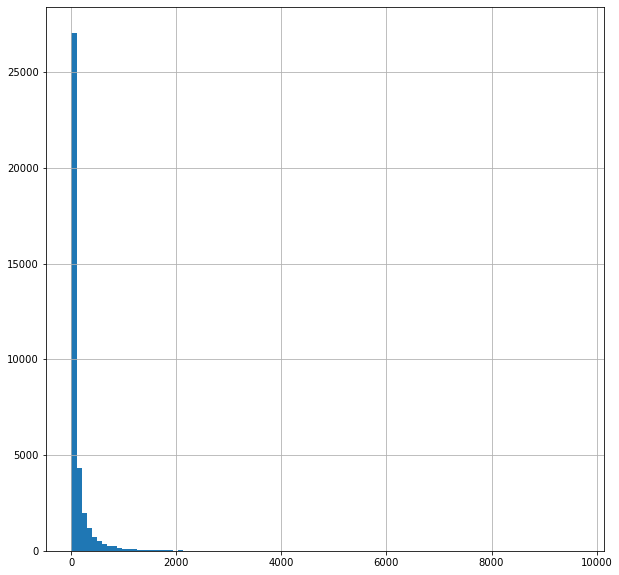

In [88]:
df_train['Number of Reviews'].hist(bins=100)

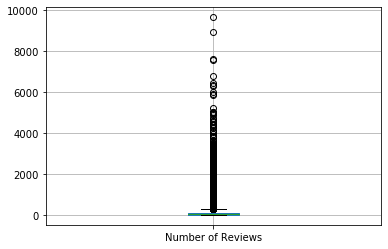

In [26]:
df_train.boxplot(['Number of Reviews'])

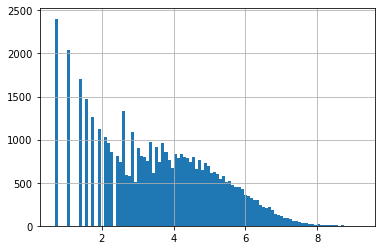

In [27]:
epsilon = 10**(-7)
df['Number of Reviews'].apply(lambda x: math.log(x+epsilon)).hist(bins=100)

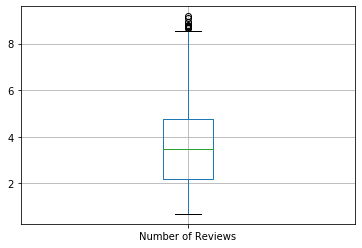

In [28]:
temp_df = df_train['Number of Reviews'].apply(lambda x: math.log(x+epsilon))
pd.DataFrame(temp_df).boxplot()

In [29]:
median = temp_df.median()
IQR = temp_df.quantile(0.75) - temp_df.quantile(0.25)
perc25 = temp_df.quantile(0.25)
perc75 = temp_df.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25),
      '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 2.1972245884473303, 75-й перцентиль: 4.744932129232815, IQR: 2.547707540785485,  Границы выбросов: [-1.624336722730897, 8.566493440411042].


In [30]:
limit_for_Number_of_Reviews = math.exp(perc75 + 1.5*IQR)
df['emis_Number_of_Reviews'] = pd.DataFrame(df['Number of Reviews']>limit_for_Number_of_Reviews).astype('float64')
df.loc[df['Number of Reviews']>limit_for_Number_of_Reviews, 'Number of Reviews']=None

df['isNAN_Number_of_Reviews'] = pd.isna(df['Number of Reviews']).astype('float64') 
# df.loc[df['Number of Reviews'].isna(), 'Number of Reviews']=None

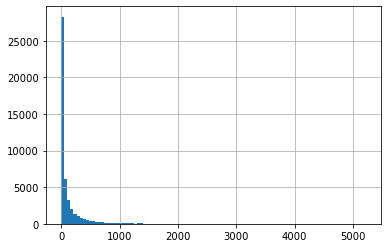

In [31]:
df['Number of Reviews'].hist(bins=100)

### 2. Price Range

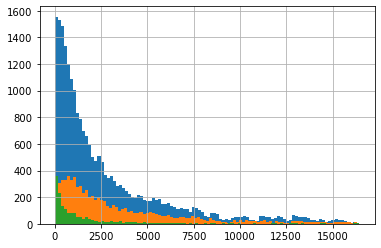

In [32]:
dic_value_Price = {'$':1,'$$ - $$$':2,'$$$$':3}
df['Price Range']=df['Price Range'].map(lambda x: dic_value_Price.get(x,x))
# посмотрим на Ranking через Price Range
for x in [2,1,3]:
    df_train['Ranking'][df_train['Price Range'] == x].hist(bins=100)
plt.show()

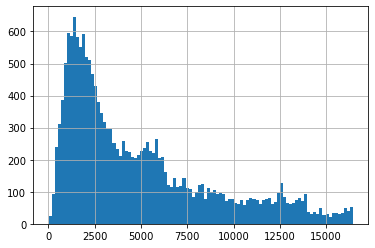

In [33]:
for x in [0]:
    df_train['Ranking'][df_train['Price Range'].isna()].hist(bins=100)
plt.show()

In [34]:
df['isNAN_Price Range'] = pd.isna(df['Price Range']).astype('float64') 

### 3. City

In [35]:
df_City_dummies = pd.get_dummies(df['City'], dummy_na=False).astype('float64')
df = pd.concat([df,df_City_dummies], axis=1)

In [36]:
df['City'].value_counts(ascending=True)

Ljubljana      222
Luxembourg     263
Bratislava     380
Helsinki       475
Oslo           488
Krakow         554
Geneva         590
Oporto         642
Zurich         685
Edinburgh      745
Athens         776
Copenhagen     819
Dublin         836
Warsaw         925
Budapest      1021
Stockholm     1033
Lyon          1126
Munich        1145
Hamburg       1186
Brussels      1314
Amsterdam     1372
Vienna        1443
Lisbon        1647
Prague        1816
Rome          2589
Milan         2694
Berlin        2705
Barcelona     3395
Madrid        3813
Paris         6108
London        7193
Name: City, dtype: int64

In [37]:
dict_numСity = {'London' : 31, 'Paris' : 30, 'Madrid' : 29, 
                  'Barcelona' : 28, 'Berlin' : 27, 'Milan' : 26, 
                  'Rome' : 25, 'Prague' : 24, 'Lisbon' : 23, 
                  'Vienna' : 22, 'Amsterdam' : 21, 
                  'Brussels' : 20, 'Hamburg' : 19, 'Munich' : 18, 
                  'Lyon' : 17, 'Stockholm' : 16, 'Budapest' : 15, 
                  'Warsaw' : 14, 'Dublin' : 13, 'Copenhagen' : 12, 
                  'Athens' : 11, 'Edinburgh' : 10, 'Zurich' : 9, 
                  'Oporto' : 8, 'Geneva' : 7, 'Krakow' : 6, 
                  'Oslo' : 5, 'Helsinki' : 4, 'Bratislava' : 3, 
                  'Luxembourg' : 2, 'Ljubljana' : 1}
df['num_Сity'] = df.apply(lambda row: float(dict_numСity[row['City']]), axis = 1)

### 4. Ranking

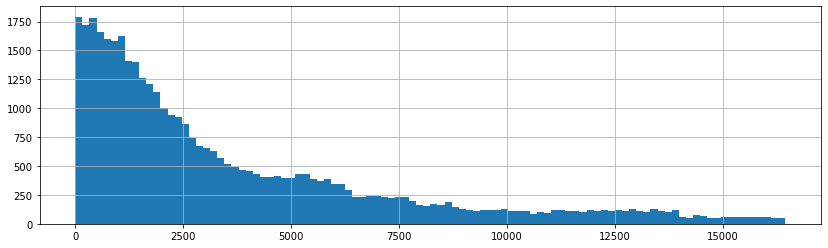

In [38]:
plt.rcParams['figure.figsize'] = (14,4)
df_train['Ranking'].hist(bins=100)

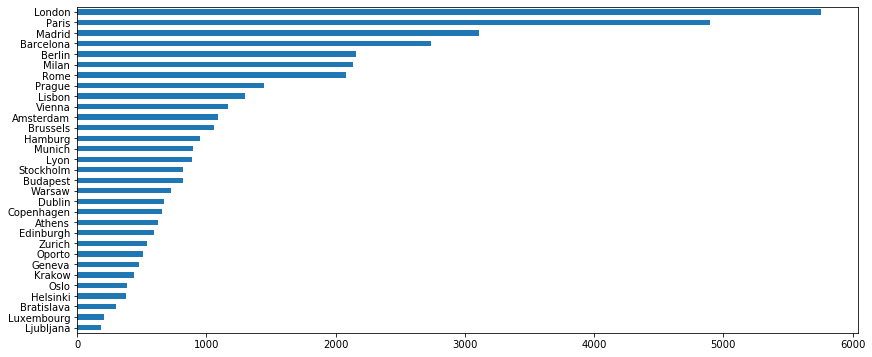

In [39]:
# У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?
plt.rcParams['figure.figsize'] = (14,6)
df_train['City'].value_counts(ascending=True).plot(kind='barh')

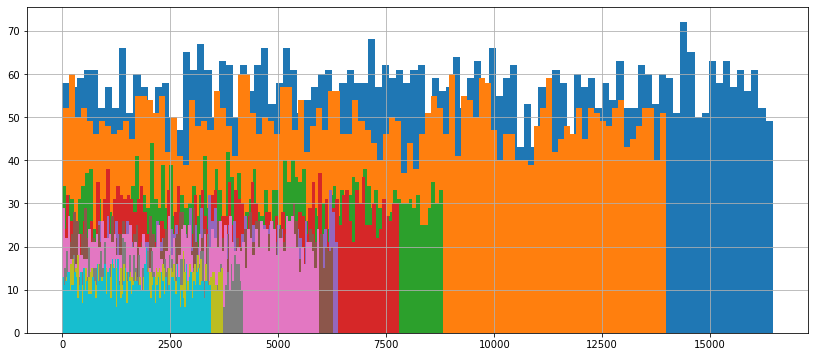

In [40]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [41]:
# Получается, что Ranking имеет нормальное распределение, 
# просто в больших городах больше ресторанов, из-за мы этого имеем смещение
# необходимо отнормировать критерий Ranking по городам City
mean_Ranking_on_City = df.groupby(['City'])['Ranking'].mean()
count_Restorant_in_City = df['City'].value_counts(ascending=False)
df['mean_Ranking_on_City'] = df['City'].apply(lambda x: mean_Ranking_on_City[x])
df['count_Restorant_in_City'] = df['City'].apply(lambda x: count_Restorant_in_City[x])
df['norm_Ranking_on_Rest_in_City'] = (df['Ranking'] - df['mean_Ranking_on_City']) / df['count_Restorant_in_City']

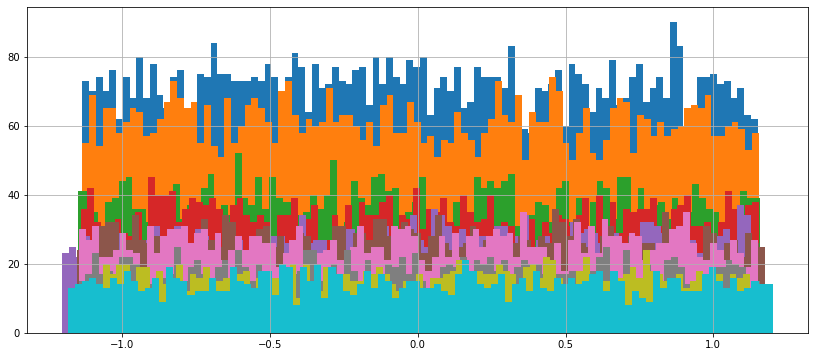

In [42]:
# посмотрим что получилось на топ 10 городов
for x in (df['City'].value_counts())[0:10].index:
    df['norm_Ranking_on_Rest_in_City'][df['City'] == x].hist(bins=100)
plt.show()

In [43]:
max_Ranking_on_City = df.groupby(['City'])['Ranking'].max()
df['max_Ranking_on_City'] = df['City'].apply(lambda x: max_Ranking_on_City[x])
df['norm_Ranking_on_maxRank_in_City'] = (df['Ranking'] - df['mean_Ranking_on_City']) / df['max_Ranking_on_City']

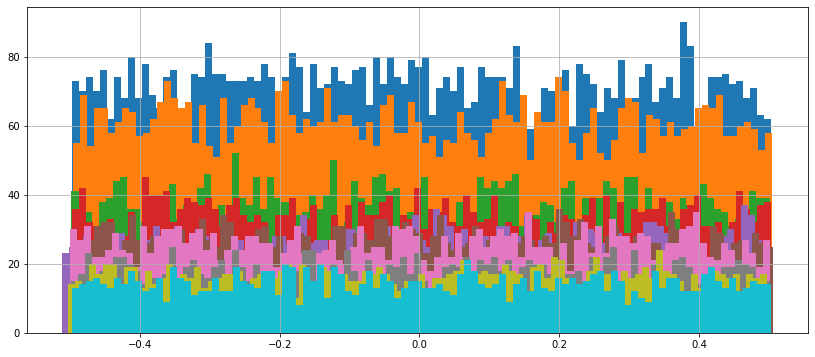

In [44]:
for x in (df['City'].value_counts())[0:10].index:
    df['norm_Ranking_on_maxRank_in_City'][df['City'] == x].hist(bins=100)
plt.show()

### 5. Cuisine Style

In [45]:
df['Cuisine Style'] = df['Cuisine Style'].fillna("['Other']")
df['Cuisine Style'] = df['Cuisine Style'].str.findall(r"'(\b.*?\b)'") 

temp_list = df['Cuisine Style'].tolist()

def list_unrar(list_of_lists):
    result=[]
    for lst in list_of_lists:
      result.extend(lst)
    return result

temp_counter=Counter(list_unrar(temp_list))

for cuisine in temp_counter:
    df[cuisine] = df['Cuisine Style'].apply(lambda x: 1 if cuisine in x else 0 ).astype('float64')

df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: len(x)).astype('float64')

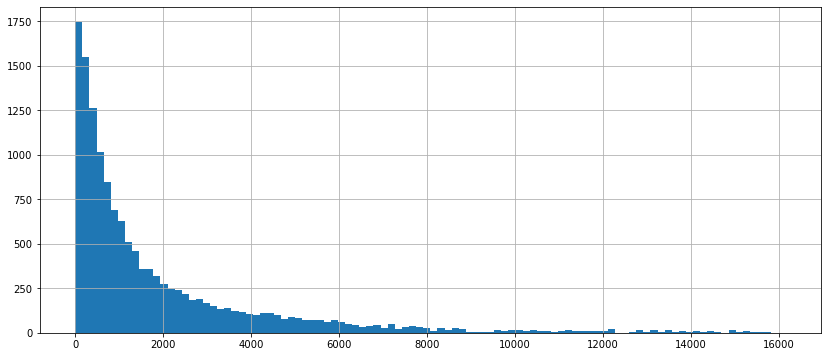

In [46]:
temp = temp_counter.most_common(5)[0][0]
df['Ranking'][df[temp] == 1].hist(bins=100)

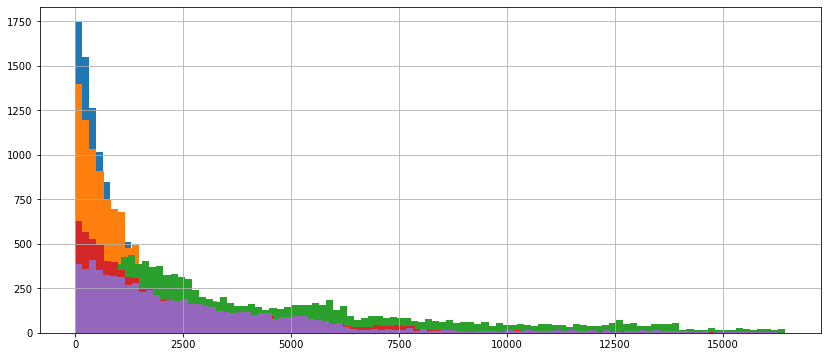

In [47]:
for x in range(5):
    temp = temp_counter.most_common(5)[x][0]
    df['Ranking'][df[temp] == 1].hist(bins=100)
plt.show()

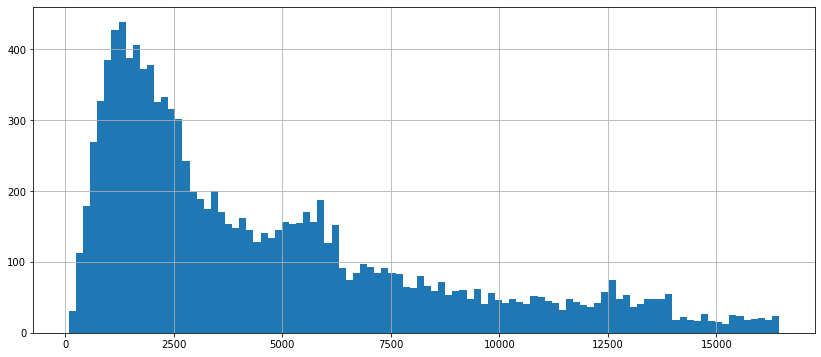

In [48]:
df['Ranking'][df['Other'] == 1].hist(bins=100)

### 6. Reviews

In [49]:
df['Reviews'] = df['Reviews'].fillna("['no_Reviews']")
df['date_of_Review'] = df['Reviews'].str.findall('\d+/\d+/\d+')

def time_to_now(row):
    if row['date_of_Review'] == []:
        return None
    return pd.datetime.now() - pd.to_datetime(row['date_of_Review']).max()

def time_between_Reviews(row):
    if row['date_of_Review'] == []:
        return None
    return pd.to_datetime(row['date_of_Review']).max() - pd.to_datetime(row['date_of_Review']).min()

df['day_to_now'] = df.apply(time_to_now, axis = 1).dt.days
df['day_between_Reviews'] = df.apply(time_between_Reviews, axis = 1).dt.days

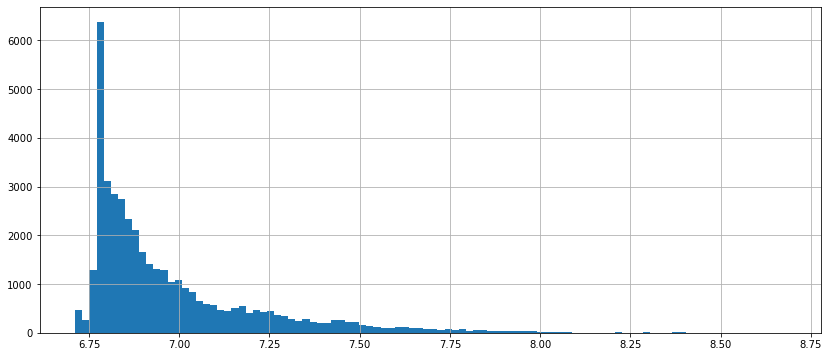

In [50]:
df['day_to_now'].apply(lambda x: math.log(x)).hist(bins=100)

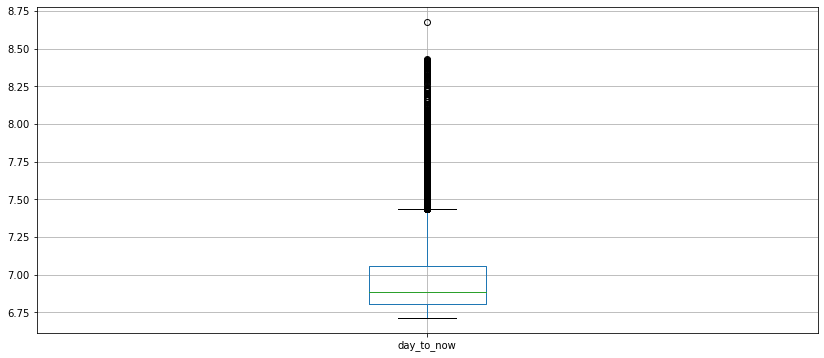

In [51]:
temp_df = df['day_to_now'].apply(lambda x: math.log(x))
pd.DataFrame(temp_df).boxplot()

In [52]:
median = temp_df.median()
IQR = temp_df.quantile(0.75) - temp_df.quantile(0.25)
perc25 = temp_df.quantile(0.25)
perc75 = temp_df.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25),
      '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 6.803505257608338, 75-й перцентиль: 7.055312843339752, IQR: 0.25180758573141393,  Границы выбросов: [6.425793879011216, 7.433024221936872].


In [53]:
limit_for_day_to_now = math.exp(perc75 + 1.5*IQR)
df['emis_day_to_now'] = pd.DataFrame(df['day_to_now']>limit_for_day_to_now).astype('float64')
df.loc[df['day_to_now']>limit_for_day_to_now, 'day_to_now']=None
df.loc[df['day_to_now'].isna(), 'day_to_now']=None

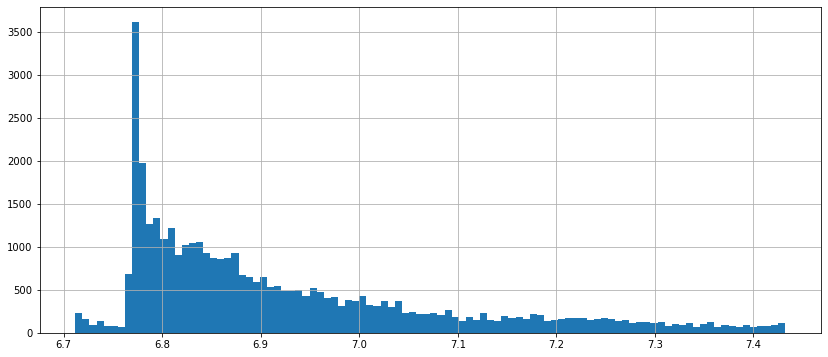

In [54]:
df['day_to_now'].apply(lambda x: math.log(x)).hist(bins=100)

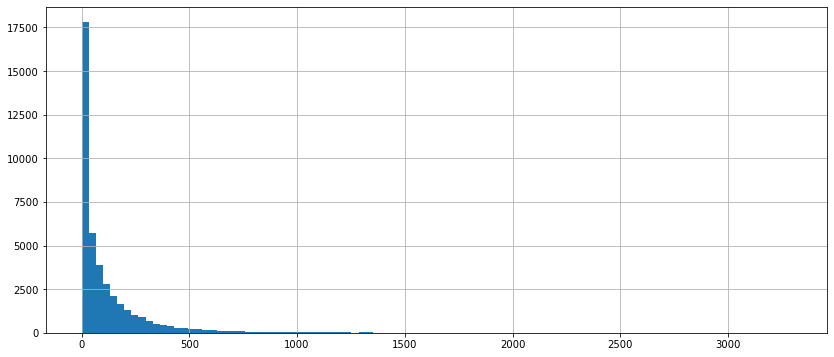

In [55]:
df['day_between_Reviews'].hist(bins=100)

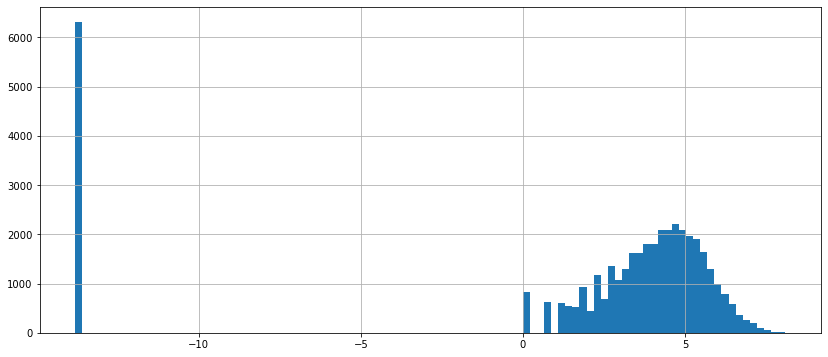

In [56]:
epsilon = 0.000001
df['day_between_Reviews'].apply(lambda x: math.log(x+epsilon)).hist(bins=100)

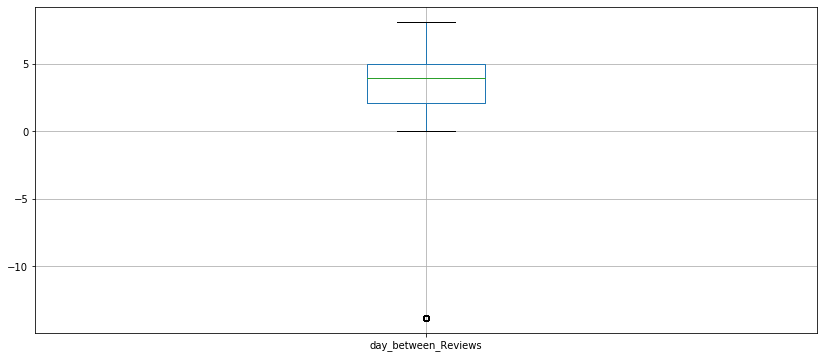

In [57]:
temp_df = df['day_between_Reviews'].apply(lambda x: math.log(x+epsilon))
pd.DataFrame(temp_df).boxplot()

In [58]:
df['emis_day_between_Reviews'] = pd.DataFrame(df['day_between_Reviews']==0).astype('float64')
df.loc[df['day_between_Reviews'] == 0, 'day_between_Reviews']=None
df.loc[df['day_between_Reviews'].isna(), 'day_between_Reviews']=None

### 7. ID_TA

In [59]:
df['code_ID_TA'] = df['ID_TA'].apply(lambda x: float(x[1:]))

### 8. URL_TA

In [60]:
df['code_after_g_URL_TA'] = df['URL_TA'].str.split('-').apply(lambda x: x[1][1:]).astype('float64')

### 9. Restaurant_id

In [61]:
df['code_Restaurant_id'] = df['Restaurant_id'].apply(lambda x: float(x[3:]))

### 10. Сity_population

In [62]:
dict_Population_Сity = {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
df['Population_Сity'] = df.apply(lambda row: dict_Population_Сity[row['City']], axis = 1)

In [63]:
# критерий Ranking по населению в городах Population_Сity
mean_Ranking_on_City = df.groupby(['City'])['Ranking'].mean()
df['mean_Ranking_on_City'] = df['City'].apply(lambda x: mean_Ranking_on_City[x])
df['norm_Ranking_on_Popul_in_City'] = (df['Ranking'] - df['mean_Ranking_on_City']) / df['Population_Сity']

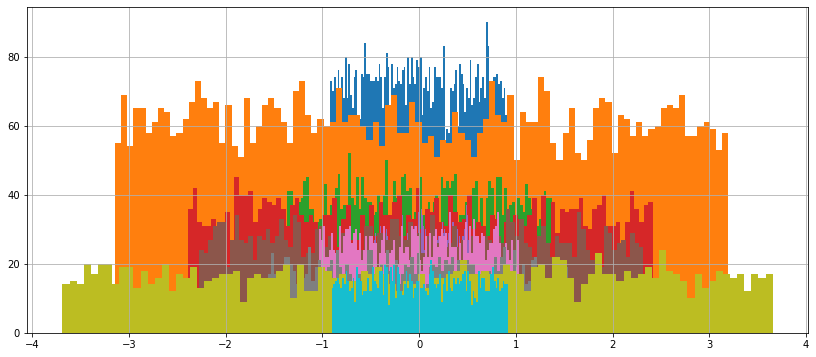

In [64]:
for x in (df['City'].value_counts())[0:10].index:
    df['norm_Ranking_on_Popul_in_City'][df['City'] == x].hist(bins=100)
plt.show()

### 11. Capital_City

In [65]:
list_Of_NotCapitalCity = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']

In [66]:
df['Capital_City'] = df['City'].apply(lambda x: 1.0 if x in list_Of_NotCapitalCity else 0.0)

### 12. Country

In [67]:
dict_Сountries = {'London' : 'England', 'Paris' : 'France', 'Madrid' : 'Spain', 
                  'Barcelona' : 'Spain', 'Berlin' : 'Germany', 'Milan' : 'Italy', 
                  'Rome' : 'Italy', 'Prague' : 'Czech_c', 'Lisbon' : 'Portugal', 
                  'Vienna' : 'Austria', 'Amsterdam' : 'Holland', 
                  'Brussels' : 'Belgium', 'Hamburg' : 'Germany', 'Munich' : 'Germany', 
                  'Lyon' : 'France', 'Stockholm' : 'Sweden', 'Budapest' : 'Romania', 
                  'Warsaw' : 'Poland', 'Dublin' : 'Ireland', 'Copenhagen' : 'Denmark', 
                  'Athens' : 'Greece', 'Edinburgh' : 'Scotland', 'Zurich' : 'Switzerland', 
                  'Oporto' : 'Portugal', 'Geneva' : 'Switzerland', 'Krakow' : 'Poland', 
                  'Oslo' : 'Norway', 'Helsinki' : 'Finland', 'Bratislava' : 'Slovakia', 
                  'Luxembourg' : 'Luxembourg_c', 'Ljubljana' : 'Slovenia'}
df['Сountries'] = df.apply(lambda row: dict_Сountries[row['City']], axis = 1)
df_Сountries = pd.get_dummies(df['Сountries'], dummy_na=False).astype('float64')
df = pd.concat([df,df_Сountries], axis=1)

## Drop

In [68]:
# удаляем все не нужное
df.drop(['Restaurant_id', 'City', 'Reviews', 'URL_TA', 'ID_TA', 'date_of_Review', 'Сountries', 'mean_Ranking_on_City', 'count_Restorant_in_City', 'max_Ranking_on_City'], axis=1, inplace=True, errors='ignore')

## StandardScaler and FillNa for all values

In [69]:
# стандартизируем все столбцы кроме целевой
def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(df[[d_col]])
    return scaler.transform(df[[d_col]])

In [70]:
for i  in list(df.columns):
    if i not in ['Rating','Sample']:
        df[i] = StandardScaler_column(i)
        if len(df[df[i].isna()]) < 50000:
            df[i] = df[i].fillna(0)

In [71]:
display(df.describe())

,Cuisine Style,Ranking,Price Range,Number of Reviews,Sample,Rating,emis_Number_of_Reviews,isNAN_Number_of_Reviews,isNAN_Price Range,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,num_Сity,norm_Ranking_on_Rest_in_City,norm_Ranking_on_maxRank_in_City,Bar,Pub,European,Scandinavian,Gluten Free Options,Vegetarian Friendly,Vegan Options,Italian,Mediterranean,Seafood,French,Cafe,Fast Food,Portuguese,Other,Greek,Czech,Eastern European,Central European,Pizza,British,Spanish,Norwegian,African,Moroccan,Middle Eastern,Halal,Indian,Thai,Dutch,Welsh,American,Steakhouse,Soups,Scottish,Fusion,Street Food,Hungarian,Asian,Wine Bar,Barbecue,Central American,Peruvian,South American,Irish,Polish,Vietnamese,Lebanese,Turkish,Healthy,Japanese,Sushi,Austrian,Chinese,Danish,International,Gastropub,...,Contemporary,Arabic,Diner,Swiss,Swedish,Persian,Australian,Grill,Mexican,Latin,Belgian,Argentinean,Tunisian,Russian,Nepali,Bangladeshi,Colombian,Sri Lankan,Pakistani,Brew Pub,Israeli,Brazilian,Delicatessen,Kosher,Ethiopian,Taiwanese,Indonesian,Malaysian,Venezuelan,Balti,Armenian,Slovenian,Caribbean,Jamaican,Ecuadorean,Chilean,Hawaiian,Minority Chinese,Croatian,Cambodian,Afghani,Tibetan,Romanian,Southwestern,Mongolian,Cajun & Creole,Singaporean,Filipino,Cuban,Native American,Canadian,Egyptian,Azerbaijani,Georgian,Yunnan,New Zealand,Ukrainian,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian,day_to_now,day_between_Reviews,emis_day_to_now,emis_day_between_Reviews,code_ID_TA,code_after_g_URL_TA,code_Restaurant_id,Population_Сity,norm_Ranking_on_Popul_in_City,Capital_City,Austria,Belgium,Czech_c,Denmark,England,Finland,France,Germany,Greece,Holland,Ireland,Italy,Luxembourg_c,Norway,Poland,Portugal,Romania,Scotland,Slovakia,Slovenia,Spain,Sweden,Switzerland
count,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.000000,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,...,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e

In [72]:
train_data = df.query('Sample == 1').drop(['Sample'], axis=1)
test_data = df.query('Sample == 0').drop(['Sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [73]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [74]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 201), (40000, 201), (40000, 200), (32000, 200), (8000, 200))

## Model

In [75]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [76]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [77]:
def classic_round(d_num):
    return int(d_num + (0.5 if d_num > 0 else -0.5))

def my_round(d_pred):
    result = classic_round(d_pred*2)/2
    if result <=5:
        return result
    else:
        return 5

my_vec_round = np.vectorize(my_round)

In [78]:
y_pred = my_vec_round(y_pred)

In [79]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
MAE = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', MAE)

MAE: 0.16375


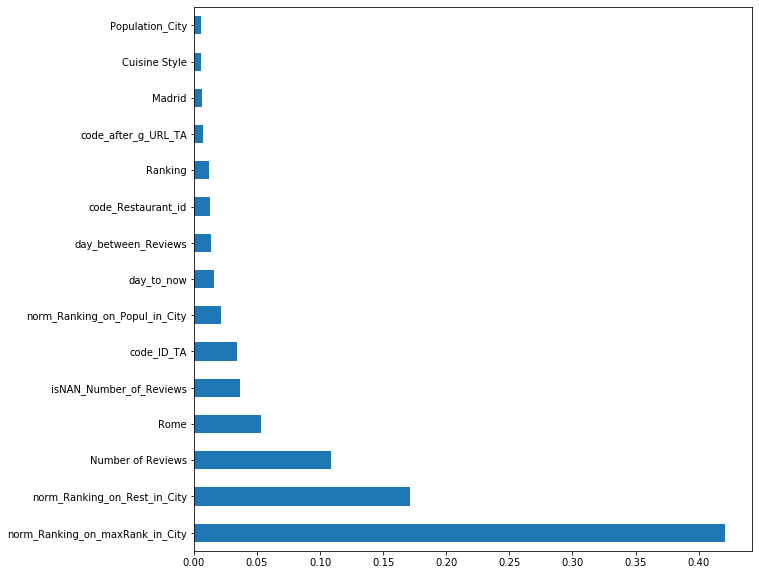

In [80]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Test optimal set of columns

In [59]:
list_ofAllColumnsSortImportant = list(feat_importances.nlargest(197).index)

In [60]:
# my_list = ['Number of Reviews', 'Ranking', 'Price Range', 
#            'Cuisine Style', 'code_ID_TA', 
#            'isNAN_Number_of_Reviews', 'isNAN_Price Range', 
#            'norm_Ranking_on_maxRank_in_City',
#            'day_between_Reviews',
#            'day_to_now', 
#            'emis_day_between_Reviews', 'emis_day_to_now', 
#            'Population_Сity']

In [61]:
# for i in my_list:
#     list_ofAllColumnsSortImportant.remove(i)

In [74]:
min_MAE = round(MAE,2)
print(f"min_MAE = {min_MAE}")
remove_list = []
log = []
k = 1
for i in range(150,180,1):
    col = list_ofAllColumnsSortImportant[-k]
    list_ofAllColumnsSortImportant.remove(col)
    print(list_ofAllColumnsSortImportant[-k])
    print(f"{i}.{col}")
    ###
    df_new = df[list_ofAllColumnsSortImportant+['Sample','Rating']]
    train_data = df_new.query('Sample == 1').drop(['Sample'], axis=1)
    test_data = df_new.query('Sample == 0').drop(['Sample'], axis=1)

    y = train_data.Rating.values            # наш таргет
    X = train_data.drop(['Rating'], axis=1)

    # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
    # выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    print(test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred = my_vec_round(y_pred)
    temp_MAE = metrics.mean_absolute_error(y_test, y_pred)
    ###
    print(temp_MAE)
    log.append([col, temp_MAE])
    if round(temp_MAE,2) <= min_MAE:
        remove_list.append(col)
        print(f"удаляем:= {col}")
    else:
        list_ofAllColumnsSortImportant.append(col)
        k += 1
        print(f"не удаляем:= {col}")
print(f"remove_list: {remove_list}")
print(f"log_list: {log}")

min_MAE = 0.17
Bratislava
150.Asian
(10000, 49) (40000, 49) (40000, 48) (32000, 48) (8000, 48)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
0.1659375
удаляем:= Asian
Barcelona
151.Bratislava
(10000, 48) (40000, 48) (40000, 47) (32000, 47) (8000, 47)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_job

In [66]:
test1_log_list = [['test', 0.166], ['Native American', 0.166], ['Xinjiang', 0.166], ['Yunnan', 0.166], ['Canadian', 0.166], ['Latvian', 0.166], ['Caucasian', 0.166], ['Salvadoran', 0.166], ['Polynesian', 0.166], ['Burmese', 0.166], ['New Zealand', 0.166], ['Albanian', 0.166], ['Azerbaijani', 0.166], ['Uzbek', 0.166], ['Minority Chinese', 0.166], ['Filipino', 0.166], ['Fujian', 0.166], ['Welsh', 0.166], ['Ecuadorean', 0.166], ['Chilean', 0.166], ['Egyptian', 0.166], ['Mongolian', 0.166], ['Singaporean', 0.166], ['Cambodian', 0.166], ['Hawaiian', 0.166], ['Slovenian', 0.166], ['Southwestern', 0.166], ['Armenian', 0.166], ['Jamaican', 0.166]]

test1_remove_list = ['Native American', 'Xinjiang', 'Yunnan', 'Canadian', 'Latvian', 'Caucasian', 'Salvadoran', 'Polynesian', 'Burmese', 'New Zealand', 'Albanian', 'Azerbaijani', 'Uzbek', 'Minority Chinese', 'Filipino', 'Fujian', 'Welsh', 'Ecuadorean', 'Chilean', 'Egyptian', 'Mongolian', 'Singaporean', 'Cambodian', 'Hawaiian', 'Slovenian', 'Southwestern', 'Armenian', 'Jamaican']
len(test1_remove_list)

28

In [67]:
test2_log_list = [['Romanian', 0.1660625], ['Tibetan', 0.165875], ['Venezuelan', 0.1664375], ['Central Asian', 0.1656875], ['Afghani', 0.166625], ['Australian', 0.1655], ['Croatian', 0.165625], ['Israeli', 0.1660625], ['Arabic', 0.167], ['Georgian', 0.165625], ['Sri Lankan', 0.1659375], ['Norwegian', 0.165125], ['Russian', 0.167625], ['Tunisian', 0.1653125], ['Caribbean', 0.166125], ['Indonesian', 0.16575], ['Persian', 0.1665], ['Bangladeshi', 0.1665], ['Ukrainian', 0.1660625], ['Central American', 0.1659375], ['Cuban', 0.1665625], ['Kosher', 0.16625], ['Colombian', 0.1658125], ['Peruvian', 0.166625], ['Ljubljana', 0.1659375], ['Argentinean', 0.1660625], ['Slovenia', 0.166375], ['Latin', 0.16575], ['Luxembourg', 0.1676875], ['Malaysian', 0.165625]]
test2_remove_list = ['Romanian', 'Tibetan', 'Venezuelan', 'Central Asian', 'Afghani', 'Australian', 'Croatian', 'Israeli', 'Arabic', 'Georgian', 'Sri Lankan', 'Norwegian', 'Russian', 'Tunisian', 'Caribbean', 'Indonesian', 'Persian', 'Bangladeshi', 'Ukrainian', 'Central American', 'Cuban', 'Kosher', 'Colombian', 'Peruvian', 'Ljubljana', 'Argentinean', 'Slovenia', 'Latin', 'Luxembourg', 'Malaysian']
len(test2_remove_list)

30

In [68]:
test3_log_list = [['Cajun & Creole', 0.166125], ['Luxembourg_c', 0.1655625], ['Moroccan', 0.1658125], ['Balti', 0.16525], ['Brazilian', 0.167], ['Swedish', 0.166125], ['Taiwanese', 0.166375], ['Norway', 0.167625], ['Irish', 0.167], ['Oslo', 0.1663125], ['Brew Pub', 0.167375], ['Korean', 0.165625], ['South American', 0.1660625], ['Eastern European', 0.166375], ['Ethiopian', 0.16725], ['Lebanese', 0.1668125], ['Swiss', 0.1668125], ['Scandinavian', 0.1673125], ['Belgium', 0.1665625], ['Brussels', 0.166625], ['Geneva', 0.1653125], ['Belgian', 0.1661875], ['Copenhagen', 0.1663125], ['Helsinki', 0.1659375], ['Denmark', 0.166], ['Diner', 0.1659375], ['Scottish', 0.1664375], ['Finland', 0.166625], ['England', 0.16625], ['emis_Number_of_Reviews', 0.1675625]]
test3_remove_list = ['Cajun & Creole', 'Luxembourg_c', 'Moroccan', 'Balti', 'Brazilian', 'Swedish', 'Taiwanese', 'Norway', 'Irish', 'Oslo', 'Brew Pub', 'Korean', 'South American', 'Eastern European', 'Ethiopian', 'Lebanese', 'Swiss', 'Scandinavian', 'Belgium', 'Brussels', 'Geneva', 'Belgian', 'Copenhagen', 'Helsinki', 'Denmark', 'Diner', 'Scottish', 'Finland', 'England', 'emis_Number_of_Reviews']
len(test3_remove_list)

30

In [70]:
test4_log_list = [['Hungarian', 0.1658125], ['London', 0.167], ['Pakistani', 0.1661875], ['Lisbon', 0.1659375], ['Street Food', 0.1664375], ['Switzerland', 0.1664375], ['Nepali', 0.1664375], ['Austrian', 0.1660625], ['Zurich', 0.165875], ['Barbecue', 0.1658125], ['Danish', 0.1661875], ['African', 0.166], ['Vienna', 0.166], ['Vietnamese', 0.1658125], ['Austria', 0.1668125], ['Middle Eastern', 0.1659375], ['Budapest', 0.167125], ['Romania', 0.165625], ['Ireland', 0.167375], ['Dublin', 0.1684375], ['Turkish', 0.166625], ['Polish', 0.167], ['Berlin', 0.166875], ['Halal', 0.166375], ['Steakhouse', 0.166875], ['Krakow', 0.16825], ['Contemporary', 0.166875], ['Central European', 0.1670625], ['Lyon', 0.1668125], ['Soups', 0.1680625]]
test4_remove_list = ['Hungarian', 'London', 'Pakistani', 'Lisbon', 'Street Food', 'Switzerland', 'Nepali', 'Austrian', 'Zurich', 'Barbecue', 'Danish', 'African', 'Vienna', 'Vietnamese', 'Austria', 'Middle Eastern', 'Budapest', 'Romania', 'Ireland', 'Dublin', 'Turkish', 'Polish', 'Berlin', 'Halal', 'Steakhouse', 'Krakow', 'Contemporary', 'Central European', 'Lyon', 'Soups']
len(test4_remove_list)

30

In [73]:
test5_log_list = [['Mexican', 0.1668125], ['Paris', 0.16775], ['Munich', 0.1656875], ['Prague', 0.1675], ['Grill', 0.166875], ['Dutch', 0.1678125], ['British', 0.1668125], ['Czech_c', 0.1685625], ['Warsaw', 0.167375], ['Sushi', 0.1673125], ['Czech', 0.1679375], ['Portugal', 0.167375], ['German', 0.1661875], ['Thai', 0.166875], ['Poland', 0.1674375], ['Milan', 0.167875], ['American', 0.167625], ['Gastropub', 0.1675], ['Japanese', 0.1675625], ['France', 0.1656875], ['Gluten Free Options', 0.166125], ['Greece', 0.166875], ['Greek', 0.1658125], ['Athens', 0.1665], ['Portuguese', 0.1681875], ['Seafood', 0.1675], ['Italy', 0.1668125], ['Wine Bar', 0.1680625], ['Delicatessen', 0.167125], ['Pub', 0.1676875]]
test5_remove_list = ['Mexican', 'Paris', 'Munich', 'Prague', 'Grill', 'Dutch', 'British', 'Czech_c', 'Warsaw', 'Sushi', 'Czech', 'Portugal', 'German', 'Thai', 'Poland', 'Milan', 'American', 'Gastropub', 'Japanese', 'France', 'Gluten Free Options', 'Greece', 'Greek', 'Athens', 'Portuguese', 'Seafood', 'Italy', 'Wine Bar', 'Delicatessen', 'Pub']
len(test5_remove_list)

30

In [75]:
test6_log_list = [['Asian', 0.1659375], ['Bratislava', 0.1661875], ['Barcelona', 0.16725], ['Fast Food', 0.165375], ['Chinese', 0.1676875], ['Oporto', 0.166875], ['Slovakia', 0.1680625], ['Hamburg', 0.168375], ['Healthy', 0.16675], ['Vegan Options', 0.1688125], ['Sweden', 0.167625], ['Bar', 0.167], ['Germany', 0.1671875], ['Stockholm', 0.16775], ['Capital_City', 0.168875], ['International', 0.1684375], ['Fusion', 0.168625], ['Cafe', 0.169125], ['Edinburgh', 0.16975], ['Vegetarian Friendly', 0.1685], ['French', 0.1684375], ['Scotland', 0.169125], ['Pizza', 0.17], ['European', 0.1679375], ['emis_day_between_Reviews', 0.169], ['Mediterranean', 0.1699375], ['Indian', 0.1698125], ['Spanish', 0.1704375], ['Italian', 0.1713125], ['Other', 0.1691875]]
test6_remove_list = ['Asian', 'Bratislava', 'Barcelona', 'Fast Food', 'Chinese', 'Oporto', 'Slovakia', 'Hamburg', 'Healthy', 'Vegan Options', 'Sweden', 'Bar', 'Germany', 'Stockholm', 'Capital_City', 'International', 'Fusion']
len(test6_remove_list)

17

## Submission

In [82]:
test_data.sample(10)

,Cuisine Style,Ranking,Price Range,Number of Reviews,Rating,emis_Number_of_Reviews,isNAN_Number_of_Reviews,isNAN_Price Range,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,num_Сity,norm_Ranking_on_Rest_in_City,norm_Ranking_on_maxRank_in_City,Bar,Pub,European,Scandinavian,Gluten Free Options,Vegetarian Friendly,Vegan Options,Italian,Mediterranean,Seafood,French,Cafe,Fast Food,Portuguese,Other,Greek,Czech,Eastern European,Central European,Pizza,British,Spanish,Norwegian,African,Moroccan,Middle Eastern,Halal,Indian,Thai,Dutch,Welsh,American,Steakhouse,Soups,Scottish,Fusion,Street Food,Hungarian,Asian,Wine Bar,Barbecue,Central American,Peruvian,South American,Irish,Polish,Vietnamese,Lebanese,Turkish,Healthy,Japanese,Sushi,Austrian,Chinese,Danish,International,Gastropub,Korean,...,Contemporary,Arabic,Diner,Swiss,Swedish,Persian,Australian,Grill,Mexican,Latin,Belgian,Argentinean,Tunisian,Russian,Nepali,Bangladeshi,Colombian,Sri Lankan,Pakistani,Brew Pub,Israeli,Brazilian,Delicatessen,Kosher,Ethiopian,Taiwanese,Indonesian,Malaysian,Venezuelan,Balti,Armenian,Slovenian,Caribbean,Jamaican,Ecuadorean,Chilean,Hawaiian,Minority Chinese,Croatian,Cambodian,Afghani,Tibetan,Romanian,Southwestern,Mongolian,Cajun & Creole,Singaporean,Filipino,Cuban,Native American,Canadian,Egyptian,Azerbaijani,Georgian,Yunnan,New Zealand,Ukrainian,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian,day_to_now,day_between_Reviews,emis_day_to_now,emis_day_between_Reviews,code_ID_TA,code_after_g_URL_TA,code_Restaurant_id,Population_Сity,norm_Ranking_on_Popul_in_City,Capital_City,Austria,Belgium,Czech_c,Denmark,England,Finland,France,Germany,Greece,Holland,Ireland,Italy,Luxembourg_c,Norway,Poland,Portugal,Romania,Scotland,Slovakia,Slovenia,Spain,Sweden,Switzerland
7715,0.205415,0.515823,0.362640,-0.430538,0.0,-0.014834,-0.261968,-0.729321,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,-0.14438,-0.129046,-0.130401,-0.122985,-0.109274,-0.155873,-0.097934,-0.10585,-0.184559,-0.066782,-0.409919,-0.072717,-0.151785,-0.287325,4.190437,-0.15309,-0.114048,-0.099278,-0.373041,-0.194136,-0.233683,-0.145244,-0.172388,-0.137291,-0.117857,0.365515,1.371899,1.365958,-0.298634,-0.255234,-0.579229,-0.095191,-0.340144,-0.624259,-0.358135,2.393065,2.322469,-0.19755,-0.293680,4.042653,-0.210525,-0.168787,-0.549313,-0.124898,-0.122985,-0.112873,-0.189145,-0.274436,-0.203699,-0.272493,-0.04386,-0.062249,-0.058924,-0.141393,-0.125311,-0.165181,-0.137139,-0.086108,-0.007746,-0.184269,-0.121638,-0.112964,-0.063213,-0.123236,-0.082252,-0.094655,-0.286222,-0.133616,-0.120019,-0.058063,-0.051057,-0.099484,-0.084202,-0.095618,-0.112235,-0.089463,-0.107765,-0.12407,-0.196564,-0.172818,-0.096572,-0.172573,-0.067233,-0.202310,-0.110949,-0.06432,...,-0.114945,-0.034079,-0.086929,-0.066933,-0.066933,-0.039273,-0.026842,-0.111777,-0.107575,-0.086695,-0.082129,-0.065562,-0.021453,-0.036356,-0.049253,-0.044766,-0.024502,-0.024502,-0.052989,-0.077563,-0.042465,-0.05522,-0.097726,-0.033485,-0.031954,-0.024502,-0.03771,-0.027579,-0.031954,-0.045655,-0.018442,-0.041266,-0.049861,-0.026842,-0.01265,-0.017891,-0.021453,-0.015494,-0.025699,-0.020981,-0.023244,-0.02409,-0.016127,-0.021914,-0.020004,-0.023244,-0.020498,-0.018442,-0.025306,-0.010001,-0.011833,-0.021914,-0.007746,-0.018977,-0.006325,-0.011833,-0.020004,-0.01265,-0.015494,-0.006325,-0.008945,-0.010001,-0.004472,-0.004472,-0.004472,-0.006325,-0.004472,0.000000,0.000000,-0.249721,-0.380070,1.691537,-0.147386,1.049838,-0.531129,1.330225,1.777856,-0.172388,-0.164284,-0.194136,-0.129046,-0.409919,-0.097934,-0.411282,-0.334665,-0.125557,-0.167971,-0.130401,2.909350,-0.072717,-0.099278,-0.17459,-0.219035,-0.14438,-0.122985,-0.087511,-0.066782,-0.410418,-0.145244,-0.161763
546,0.205415,-0.620917,0.362640,-0.320

In [83]:
test_data = test_data.drop(['Rating'], axis=1)

In [84]:
sample_submission = pd.read_csv('../kaggle/data/sample_submission.csv')
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [85]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [86]:
predict_submission=my_vec_round(predict_submission)
predict_submission

array([3. , 4. , 4. , ..., 3. , 4.5, 4. ])

In [87]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
